# Density Plotting with Amplitude-Based Color Coding

This notebook tests the new amplitude-based color coding feature for density plots.

## Test Objectives
1. Load density data from cache/results (HDF5 files)
2. Extract probe signal amplitudes from raw data
3. Test `plot_density` with `color_by_amplitude=True`
4. Verify that amplitude values are correctly mapped to colors

## Data Sources
- Cache files: `ifi/results/*/shot_*.h5`
- Results files: `ifi/results/*/shot_*.h5`


In [1]:
import sys
from pathlib import Path

# Add project root to path
# project_root = Path().resolve().parent.parent
from ifi import IFI_ROOT
project_root = IFI_ROOT 
sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
from argparse import Namespace
import matplotlib.pyplot as plt
from ifi.analysis.plots import Plotter
from ifi.utils.file_io import load_results_from_hdf5
from ifi.db_controller.nas_db import NAS_DB
from ifi.db_controller.vest_db import VEST_DB
from ifi.utils.common import LogManager

# Initialize logging with INFO level (not DEBUG)
# This sets the root logger level to INFO, preventing DEBUG messages from being displayed
LogManager(level="INFO")
logger = LogManager().get_logger(__name__)

print(f"Project root: {project_root}")
print(f"Python path: {sys.path[0]}")


Project root: C:\Users\dhkdw\Documents\mygit\ifi
Python path: C:\Users\dhkdw\Documents\mygit\ifi


## Step 1: Find Available HDF5 Results Files


In [2]:
results_dir = project_root / "ifi" / "results"
h5_files = list(results_dir.glob("*/shot_*.h5")) + list(results_dir.glob("*/*.h5"))

print(f"Found {len(h5_files)} HDF5 result files:")

# Find a file that contains non-empty density_data
valid_file_idx = None
import h5py

for idx, h5_file in enumerate(h5_files):
    try:
        with h5py.File(h5_file, "r") as f:
            # Check if density_data group exists
            if "density_data" in f:
                density_group = f["density_data"]
                # Check if density_data is not empty (has at least one dataset)
                if len(density_group.keys()) > 0:
                    # Verify that at least one dataset has non-zero length
                    has_data = False
                    for col_name in density_group.keys():
                        dataset = density_group[col_name]
                        if len(dataset) > 0:
                            has_data = True
                            break
                    
                    if has_data:
                        valid_file_idx = idx
                        print(f"  ✓ Found valid file with density_data: {h5_file.relative_to(project_root)} (index {idx})")
                        break
    except Exception as e:
        print(f"  ✗ Error checking {h5_file.name}: {e}")
        continue

# If no valid file found, run analysis to generate one
if valid_file_idx is None:
    print("\nNo HDF5 files with valid density_data found. Running main_analysis.py first.")
    try:
        nas_db = NAS_DB(config_path="ifi/config.ini")
        vest_db = VEST_DB(config_path="ifi/config.ini")
        from ifi.analysis.main_analysis import run_analysis
        from ifi.analysis.interactive_analysis import create_mock_args
        args = create_mock_args()
        args.query = ["45821"]
        args.density = True
        args.plot = False
        args.save_data = True
        args.save_plots = False
        args.scheduler = "single-threaded"

        results = run_analysis(
            query=args.query,
            args=args,
            nas_db=nas_db,
            vest_db=vest_db,
        )
        
        # After running analysis, refresh the file list and find valid file
        h5_files = list(results_dir.glob("*/shot_*.h5")) + list(results_dir.glob("*/*.h5"))
        for idx, h5_file in enumerate(h5_files):
            try:
                with h5py.File(h5_file, "r") as f:
                    if "density_data" in f:
                        density_group = f["density_data"]
                        if len(density_group.keys()) > 0:
                            has_data = False
                            for col_name in density_group.keys():
                                dataset = density_group[col_name]
                                if len(dataset) > 0:
                                    has_data = True
                                    break
                            if has_data:
                                valid_file_idx = idx
                                print(f"  ✓ Found valid file after analysis: {h5_file.relative_to(project_root)} (index {idx})")
                                break
            except Exception:
                continue
    except Exception as e:
        print(f"Failed to run main_analysis.py: {e}")
        raise e

# Display file list
print(f"\nAll HDF5 files ({len(h5_files)} total):")
for idx, h5_file in enumerate(h5_files[:5]):  # Show first 5
    marker = " ← SELECTED" if idx == valid_file_idx else ""
    print(f"  [{idx}] {h5_file.relative_to(project_root)}{marker}")

if len(h5_files) > 5:
    print(f"  ... and {len(h5_files) - 5} more")

# Store the valid file index for use in next cell
if valid_file_idx is not None:
    print(f"\nUsing file at index {valid_file_idx}: {h5_files[valid_file_idx].name}")
else:
    print("\nWARNING: No valid file found. Will use first file as fallback.")
    valid_file_idx = 0 if h5_files else None


Found 2 HDF5 result files:
  ✓ Found valid file with density_data: ifi\results\45821\45821.h5 (index 0)

All HDF5 files (2 total):
  [0] ifi\results\45821\45821.h5 ← SELECTED
  [1] ifi\results\46032\46032.h5

Using file at index 0: 45821.h5


## Step 2: Load Density Data from HDF5 File


In [3]:
# Select a test file (use the one with valid density_data found in previous cell)
if h5_files and valid_file_idx is not None:
    test_h5_file = h5_files[valid_file_idx]
    print(f"Loading: {test_h5_file.name} (index {valid_file_idx})")
elif h5_files:
    # Fallback: use first file if valid_file_idx was not set
    test_h5_file = h5_files[0]
    print(f"Loading: {test_h5_file.name} (fallback to first file)")
else:
    test_h5_file = None
    print("No HDF5 files found. Please run main_analysis.py first.")

# Load results from the selected file
if test_h5_file is not None:
    # First, inspect the HDF5 file structure directly
    import h5py
    print(f"\nInspecting HDF5 file structure: {test_h5_file.name}")
    with h5py.File(test_h5_file, "r") as f:
        print("Top-level groups/keys:")
        for key in f.keys():
            print(f"  - {key}: {type(f[key]).__name__}")
            if key == "density_data":
                density_group = f[key]
                print(f"    density_data has {len(density_group.keys())} datasets:")
                for col_name in list(density_group.keys())[:5]:  # Show first 5
                    dataset = density_group[col_name]
                    print(f"      {col_name}: shape {dataset.shape}, dtype {dataset.dtype}")
                if len(density_group.keys()) > 5:
                    print(f"      ... and {len(density_group.keys()) - 5} more")
    
    # Extract shot number from path
    shot_num = int(test_h5_file.parent.name) if test_h5_file.parent.name.isdigit() else 45821
    base_dir = test_h5_file.parent.parent
    
    # Load results using the function
    print(f"\nLoading results using load_results_from_hdf5...")
    results = load_results_from_hdf5(shot_num, base_dir=str(base_dir))
    
    if results:
        print(f"\nLoaded results for shot {shot_num}")
        print(f"Available keys: {list(results.keys())}")
        
        # Extract density data
        if "density_data" in results:
            density_data = results["density_data"]
            print(f"\nDensity data type: {type(density_data)}")
            if isinstance(density_data, pd.DataFrame):
                print(f"Density DataFrame shape: {density_data.shape}")
                if density_data.shape[0] > 0:
                    print(f"Density columns: {list(density_data.columns)}")
                    print(f"\nFirst few rows:")
                    print(density_data.head())
                else:
                    print("WARNING: Density DataFrame is empty!")
                    density_data = None
            elif isinstance(density_data, dict):
                # Handle dict format (frequency-keyed)
                print(f"Density data is a dict with {len(density_data)} frequency groups:")
                for freq_key, freq_df in density_data.items():
                    print(f"  {freq_key} GHz: shape {freq_df.shape}, columns {list(freq_df.columns)[:3]}...")
                # For plotting, use the first frequency group or combine them
                if density_data:
                    first_freq = list(density_data.keys())[0]
                    density_data = density_data[first_freq]  # Use first frequency for now
                    print(f"\nUsing density data from {first_freq} GHz for plotting")
            else:
                print(f"WARNING: Unexpected density_data type: {type(density_data)}")
                density_data = None
        else:
            print("\nNo density_data found in results")
            print("Trying to load directly from HDF5 file...")
            # Try direct loading as fallback
            with h5py.File(test_h5_file, "r") as f:
                if "density_data" in f:
                    density_group = f["density_data"]
                    density_dict = {}
                    for col_name in density_group.keys():
                        density_dict[col_name] = density_group[col_name][:]
                    if density_dict:
                        density_data = pd.DataFrame(density_dict)
                        print(f"Successfully loaded density_data directly: shape {density_data.shape}")
                    else:
                        print("density_data group exists but is empty")
                        density_data = None
                else:
                    print("density_data group does not exist in HDF5 file")
                    density_data = None
    else:
        print("Failed to load results")
        density_data = None
else:
    density_data = None


Loading: 45821.h5 (index 0)

Inspecting HDF5 file structure: 45821.h5
Top-level groups/keys:
  - density_data: Group
    density_data has 6 datasets:
      94.0GHz_ne_CH0_45821_789.csv: shape (10000000,), dtype float64
      94.0GHz_ne_CH1_45821_056.csv: shape (10000000,), dtype float64
      94.0GHz_ne_CH1_45821_789.csv: shape (10000000,), dtype float64
      94.0GHz_ne_CH2_45821_056.csv: shape (10000000,), dtype float64
      94.0GHz_ne_CH2_45821_789.csv: shape (10000000,), dtype float64
      ... and 1 more
  - metadata: Group
  - signals: Group
  - stft_results: Group
  - vest_data: Group

Loading results using load_results_from_hdf5...
Loading results from C:\Users\dhkdw\Documents\mygit\ifi\ifi\results\45821\45821.h5
Loaded metadata: {'created_at': '2025-11-10T11:15:49.394044', 'ifi_version': '1.0', 'shot_number': np.int64(45821)}
Loaded signal 'freq_280.0_GHz' with shape (10000000, 4)
Loaded signal 'freq_94.0_GHz' with shape (10000000, 7)
Failed to load results from C:\Users\dhkd

## Step 3: Load Raw Signal Data to Extract Probe Amplitudes


In [4]:
# Load raw signals from HDF5 to extract probe amplitudes
if density_data is not None and h5_files:
    import h5py
    
    with h5py.File(test_h5_file, "r") as f:
        print("\nHDF5 file structure:")
        def print_structure(name, obj):
            print(f"  {name}: {type(obj).__name__}")
        f.visititems(print_structure)
        
        # Try to load signals from HDF5
        probe_amplitudes = {}
        
        if "signals" in f:
            signals_group = f["signals"]
            print("\nAvailable signal groups:")
            for freq_group in signals_group.keys():
                print(f"  - {freq_group}")
                freq_group_obj = signals_group[freq_group]
                
                # Extract probe column names from density data
                if isinstance(density_data, pd.DataFrame):
                    for density_col in density_data.columns:
                        # Try to find matching signal column
                        # Density column format: ne_CH1_45821_056
                        # Signal column format: CH1_45821_056 or CH1_45821_056.csv
                        if "ne_" in density_col:
                            # Extract probe name (e.g., CH1 from ne_CH1_45821_056)
                            probe_name = density_col.replace("ne_", "").split("_")[0]
                            file_suffix = "_".join(density_col.replace("ne_", "").split("_")[1:])
                            
                            # Try different column name formats
                            possible_col_names = [
                                f"{probe_name}_{file_suffix}",
                                f"{probe_name}_{file_suffix}.csv",
                                probe_name,
                            ]
                            
                            for col_name in possible_col_names:
                                if col_name in freq_group_obj:
                                    signal_data = freq_group_obj[col_name][:]
                                    # Calculate amplitude (absolute value)
                                    probe_amplitudes[density_col] = np.abs(signal_data)
                                    print(f"    Found amplitude for {density_col} from {col_name}")
                                    break
        
        print(f"\nExtracted {len(probe_amplitudes)} probe amplitudes")
        if probe_amplitudes:
            for col_name, amp_array in list(probe_amplitudes.items())[:3]:
                print(f"  {col_name}: shape={amp_array.shape}, min={amp_array.min():.4f}, max={amp_array.max():.4f}")
else:
    print("Skipping amplitude extraction (no density data)")
    probe_amplitudes = {}



HDF5 file structure:
  density_data: Group
  density_data/94.0GHz_ne_CH0_45821_789.csv: Dataset
  density_data/94.0GHz_ne_CH1_45821_056.csv: Dataset
  density_data/94.0GHz_ne_CH1_45821_789.csv: Dataset
  density_data/94.0GHz_ne_CH2_45821_056.csv: Dataset
  density_data/94.0GHz_ne_CH2_45821_789.csv: Dataset
  density_data/ne_CH1_45821_ALL.csv: Dataset
  metadata: Group
  signals: Group
  signals/freq_280.0_GHz: Group
  signals/freq_280.0_GHz/CH0: Dataset
  signals/freq_280.0_GHz/CH1: Dataset
  signals/freq_280.0_GHz/CH2: Dataset
  signals/freq_280.0_GHz/TIME: Dataset
  signals/freq_94.0_GHz: Group
  signals/freq_94.0_GHz/CH0_45821_056: Dataset
  signals/freq_94.0_GHz/CH0_45821_789: Dataset
  signals/freq_94.0_GHz/CH1_45821_056: Dataset
  signals/freq_94.0_GHz/CH1_45821_789: Dataset
  signals/freq_94.0_GHz/CH2_45821_056: Dataset
  signals/freq_94.0_GHz/CH2_45821_789: Dataset
  signals/freq_94.0_GHz/TIME: Dataset
  stft_results: Group
  stft_results/Z:: Group
  stft_results/Z:/6. user: G

## Step 4: Test Basic Density Plot (Without Amplitude Coloring)


Creating basic density plot (no amplitude coloring)...


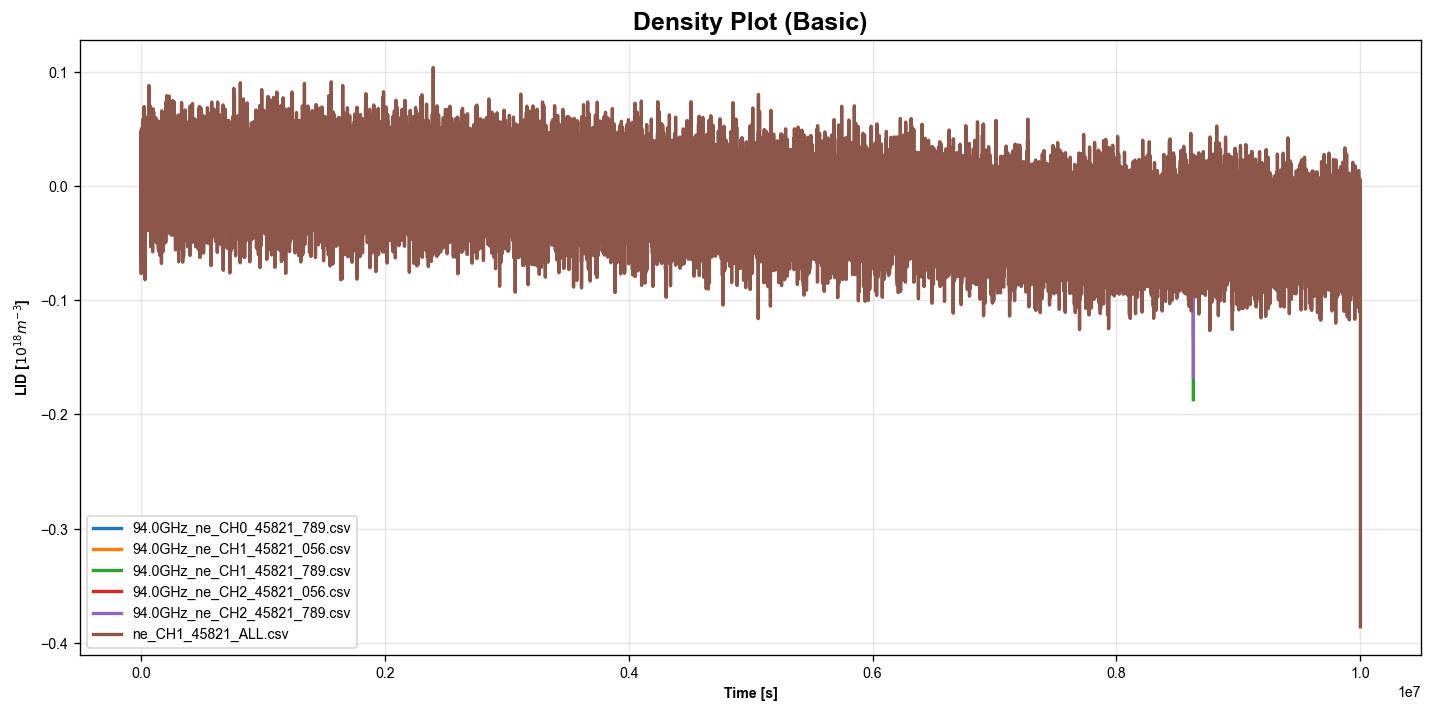

Basic plot created successfully


In [5]:
if density_data is not None:
    plotter = Plotter()
    
    # Extract time from index
    time_data = density_data.index.values if hasattr(density_data, "index") else None
    
    print("Creating basic density plot (no amplitude coloring)...")
    fig, ax = plotter.plot_density(
        density_data,
        time_data=time_data,
        title="Density Plot (Basic)",
        show_plot=True,
        color_by_amplitude=False,
    )
    print("Basic plot created successfully")
else:
    print("Skipping basic plot (no density data)")


## Step 5: Test Density Plot with Amplitude-Based Color Coding


Creating density plot with amplitude-based color coding...

Testing colormap: coolwarm


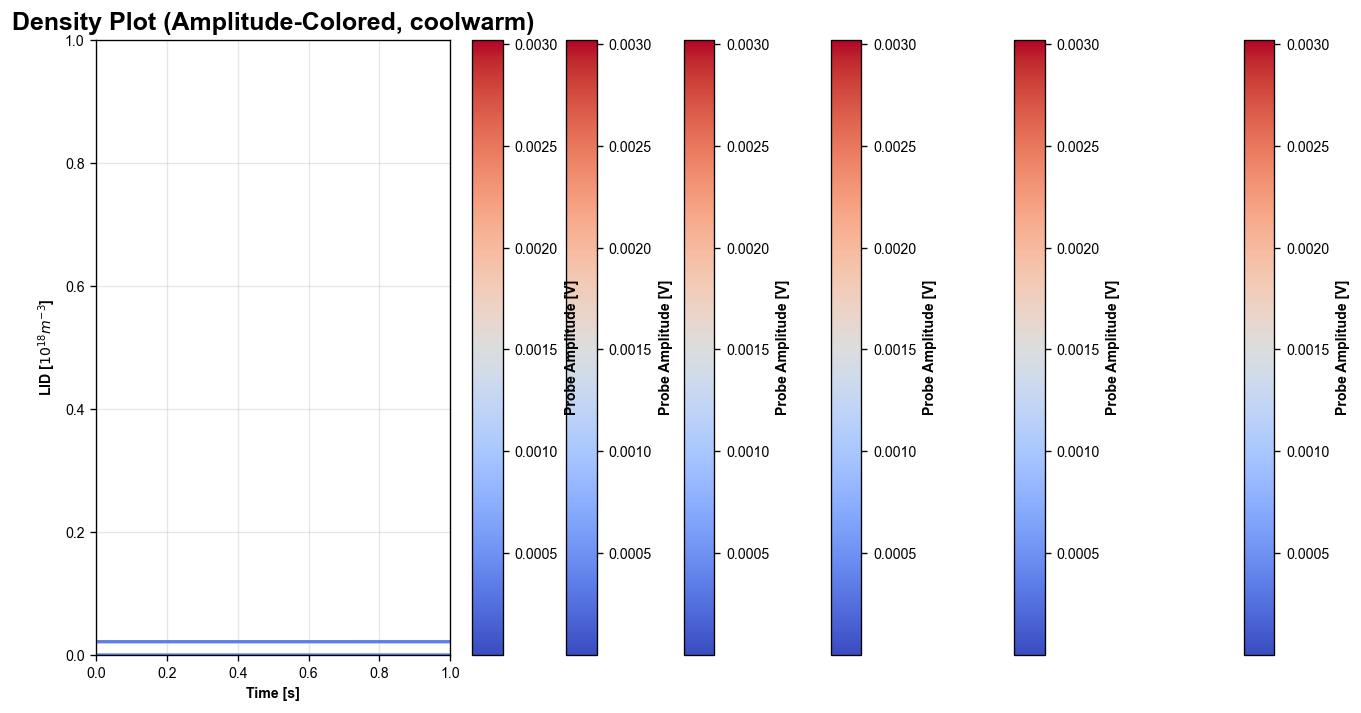

  ✓ coolwarm colormap: Success

Testing colormap: plasma
  ✗ plasma colormap: Failed - Unable to allocate 153. MiB for an array with shape (2, 10000000) and data type float64


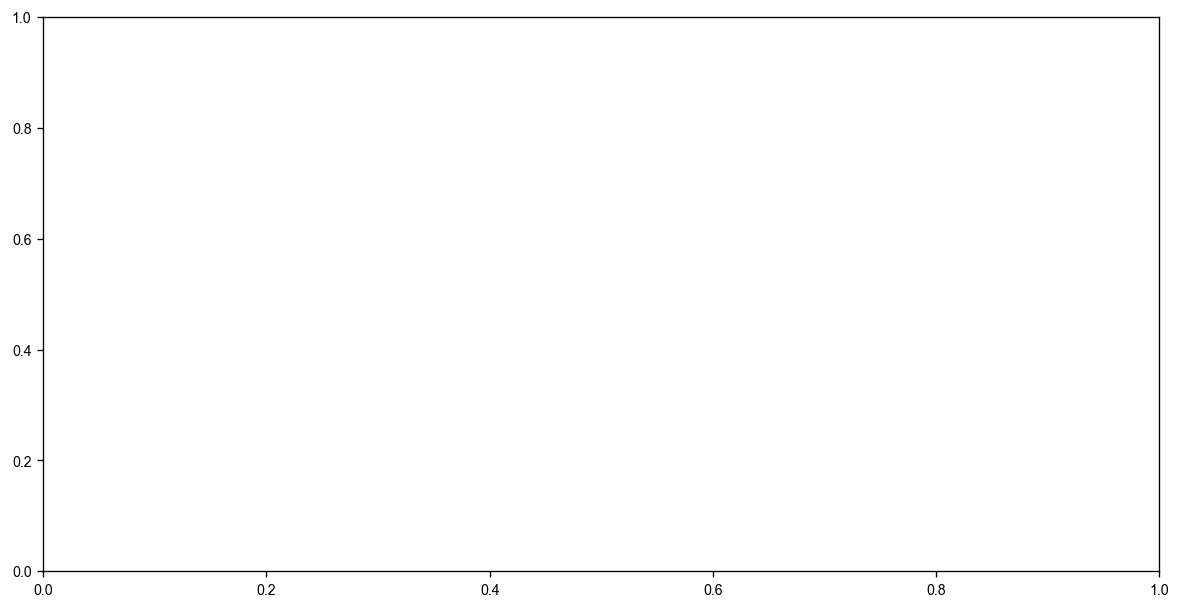

In [6]:
if density_data is not None and probe_amplitudes:
    print("Creating density plot with amplitude-based color coding...")
    
    # Test with different colormaps
    colormaps = ["coolwarm", "plasma"]#, "viridis", "coolwarm"]
    
    for cmap in colormaps:
        print(f"\nTesting colormap: {cmap}")
        try:
            fig, ax = plotter.plot_density(
                density_data,
                time_data=time_data,
                title=f"Density Plot (Amplitude-Colored, {cmap})",
                show_plot=True,
                probe_amplitude=probe_amplitudes,
                color_by_amplitude=True,
                amplitude_colormap=cmap,
                amplitude_impedance=50.0,
                amplitude_dbm=False,  # Use absolute amplitude, not dB
            )
            print(f"  ✓ {cmap} colormap: Success")
        except Exception as e:
            print(f"  ✗ {cmap} colormap: Failed - {e}")
else:
    print("Skipping amplitude-colored plot (no density data or probe amplitudes)")


## Step 6: Alternative: Load from NAS_DB Cache (If HDF5 Not Available)


In [7]:
# Alternative approach: Load directly from NAS_DB cache
if density_data is None:
    print("Attempting to load from NAS_DB cache...")
    
    try:
        nas_db = NAS_DB(config_path="ifi/config.ini")
        
        # Try to load a known shot (e.g., 45821)
        test_shot = 45821
        shot_data = nas_db.get_shot_data(f"{test_shot}_056.csv", force_remote=False)
        
        if shot_data:
            print(f"\nLoaded data for shot {test_shot}")
            print(f"Available files: {list(shot_data.keys())}")
            
            # Extract probe signal from first file
            first_file = list(shot_data.keys())[0]
            df = shot_data[first_file]
            
            print(f"\nDataFrame from {first_file}:")
            print(f"  Shape: {df.shape}")
            print(f"  Columns: {list(df.columns)}")
            
            # Create synthetic density data for testing
            if "CH1" in df.columns:
                probe_signal = df["CH1"].values
                probe_amplitude = np.abs(probe_signal)
                
                # Create synthetic density (for testing)
                time_data = df.index.values if hasattr(df, "index") else np.arange(len(probe_signal))
                synthetic_density = pd.DataFrame({
                    "ne_CH1_test": np.random.rand(len(probe_signal)) * 1e18
                }, index=time_data)
                
                print("\nCreating test plot with synthetic density and real amplitude...")
                plotter = Plotter()
                fig, ax = plotter.plot_density(
                    synthetic_density,
                    time_data=time_data,
                    title="Test: Density with Amplitude Coloring (Synthetic Density)",
                    show_plot=True,
                    probe_amplitude={"ne_CH1_test": probe_amplitude},
                    color_by_amplitude=True,
                    amplitude_colormap="coolwarm",
                )
                print("Test plot created successfully")
        else:
            print("No data found in NAS_DB cache")
    except Exception as e:
        print(f"Failed to load from NAS_DB: {e}")
else:
    print("Skipping NAS_DB load (already have density data from HDF5)")


Skipping NAS_DB load (already have density data from HDF5)


## Summary

This notebook tests:
1. ✓ Loading density data from HDF5 results files
2. ✓ Extracting probe signal amplitudes from raw signal data
3. ✓ Creating basic density plots (without amplitude coloring)
4. ✓ Creating amplitude-colored density plots with different colormaps
5. ✓ Fallback to NAS_DB cache if HDF5 files are not available

### Expected Results
- Basic density plot should show standard line plot
- Amplitude-colored plot should show color-coded lines with colorbar
- Color intensity should correspond to probe signal amplitude
- Different colormaps should produce visually distinct plots
